In [1]:
import sys
sys.path.append('..//')

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from parsmooth._base import MVNStandard, FunctionalModel
from parsmooth.linearization import extended, second_order
from bearing_data import get_data, make_parameters
from parsmooth.sequential._ls_newton import _iterated_recursive_newton_smoother
from parsmooth.sequential._ls_gn import _iterated_recursive_gauss_newton_smoother
from parsmooth.sequential._ls_newton import log_posterior


In [2]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise
T = 500
Q, R, observation_function, transition_function, _, _ = make_parameters(qc, qw, r, dt, s1, s2)
_, true_states, ys = get_data(x0, dt, r, T, s1, s2, random_state=42)
m0 = jnp.array([-4., -1., 2., 7., 3.])
P0 = jnp.eye(5)

nx = 5
init = MVNStandard(mean=jnp.array([-1., -1., 0., 0., 0.]),
                           cov=jnp.eye(nx))

initial_states =  MVNStandard(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                                                                 jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))

transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

2023-03-01 14:56:36.175785: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [3]:
# Newton Recursive Iterated Smoother
def iterated_recursive_newton_smoother(iteration, nominal_trajectory):
    newton_smoothed_recursive = _iterated_recursive_newton_smoother(ys, init,transition_model,
                                                                    observation_model,second_order,
                                                                    extended, nominal_trajectory
                                                                    ,n_iter=iteration)[0]
    return newton_smoothed_recursive

# Gauss-Newton recursive Iterated Smoother
def  iterated_recursive_gauss_newton_smoother(iteration, nominal_trajectory):
    gauss_newton_smoothed_recursive = _iterated_recursive_gauss_newton_smoother(ys, init,
                                                                                transition_model, observation_model
                                                                                ,extended, nominal_trajectory,
                                                                                n_iter=iteration)[0]

    return gauss_newton_smoothed_recursive

def cost_function(nominal_trajectory):
    return log_posterior(nominal_trajectory, ys,
                         init, transition_model, observation_model)


In [4]:
n_run = 20

In [5]:
max_iter = 25
curr_nominal_trajectory_n = initial_states
curr_nominal_trajectory_gn = initial_states
newton_cost = []
gauss_newton_cost = []
for i in range(max_iter):
    print(i, end="\r")
    curr_nominal_trajectory_n = iterated_recursive_newton_smoother(i+1, curr_nominal_trajectory_n)
    curr_nominal_trajectory_gn = iterated_recursive_gauss_newton_smoother(i+1, curr_nominal_trajectory_gn)

    newton_cost.append(cost_function(curr_nominal_trajectory_n.mean))
    gauss_newton_cost.append(cost_function(curr_nominal_trajectory_gn.mean))


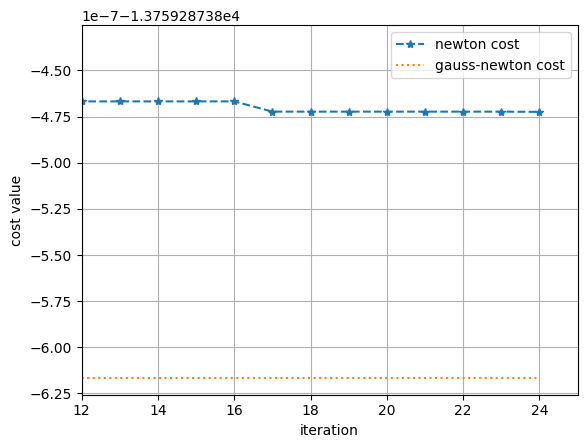

In [35]:
from matplotlib import pyplot as plt
j = 11
plt.plot(jnp.arange(j, max_iter), newton_cost[j:], "*--", label="newton cost")
plt.plot(jnp.arange(j, max_iter), gauss_newton_cost[j:], ':', label="gauss-newton cost")
plt.legend()
plt.grid()
plt.ylabel("cost value")
plt.xlabel("iteration")
plt.xlim([j+1, max_iter]);

In [37]:
newton_cost

[Array(7937161.10845407, dtype=float64),
 Array(632374.06898862, dtype=float64),
 Array(375623.5727622, dtype=float64),
 Array(170021.84422817, dtype=float64),
 Array(65986.33179652, dtype=float64),
 Array(20919.90070435, dtype=float64),
 Array(-5928.50208878, dtype=float64),
 Array(-11090.11868942, dtype=float64),
 Array(-12564.4344113, dtype=float64),
 Array(-13249.97370087, dtype=float64),
 Array(-13729.26030881, dtype=float64),
 Array(-13759.28737843, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64),
 Array(-13759.28737847, dtype=float64)]

In [9]:
# This doesn't work, check https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html'

# def body(carry, _):
#     curr_nominal_trajectory_gn, curr_nominal_trajectory_n, iteration_ = carry
#     gauss_newton_smoothed = _iterated_recursive_gauss_newton_smoother(ys, init,
#                                                                       transition_model, observation_model
#                                                                       ,extended, curr_nominal_trajectory_gn,
#                                                                        n_iter=iteration_)[0]
#     newton_smoothed = _iterated_recursive_newton_smoother(ys, init,transition_model,
#                                                                     observation_model,second_order,
#                                                                     extended, curr_nominal_trajectory_n
#                                                                     ,n_iter=iteration_)[0]
#
#     # newton_smoothed = iterated_recursive_newton_smoother(iter, curr_nominal_trajectory_n)
#     newton_cost = cost_function(newton_smoothed.mean)
#     # gauss_newton_smoothed = iterated_recursive_gauss_newton_smoother(iter, curr_nominal_trajectory_gn)
#     gauss_newton_cost = cost_function(gauss_newton_smoothed.mean)
#     return (gauss_newton_smoothed, newton_smoothed, iter + 1), jnp.concatenate([jnp.array(newton_cost), jnp.array(gauss_newton_cost)])
#
# (_,_), costs = jax.lax.scan(body, (initial_states, initial_states, 1.), jnp.arange(max_iter))

